23:56:13 - cmdstanpy - INFO - Chain [1] start processing
23:56:13 - cmdstanpy - INFO - Chain [1] done processing


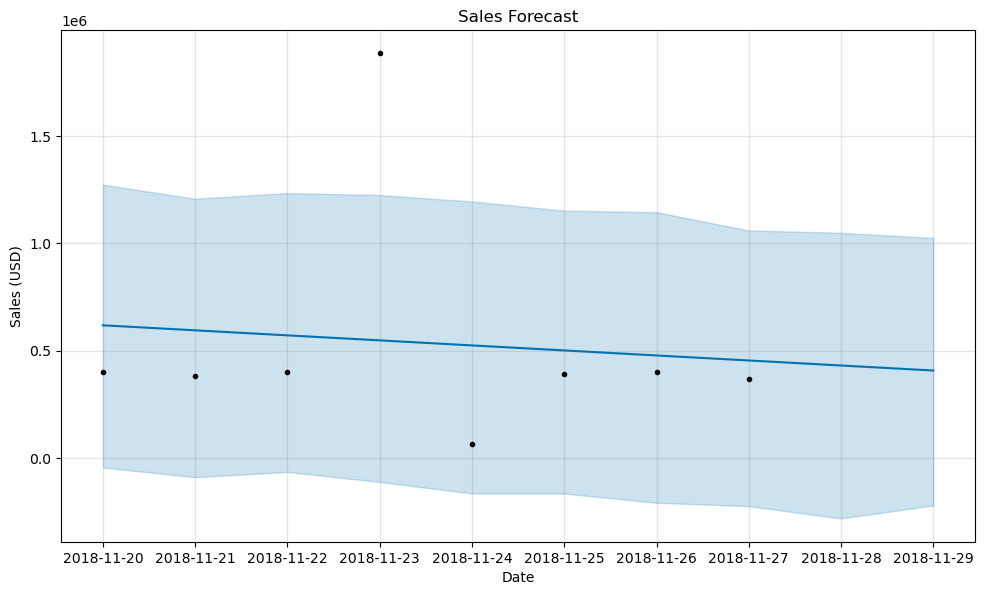

🔍 RMSE: 463500.51
🔍 MAE: 272030.34


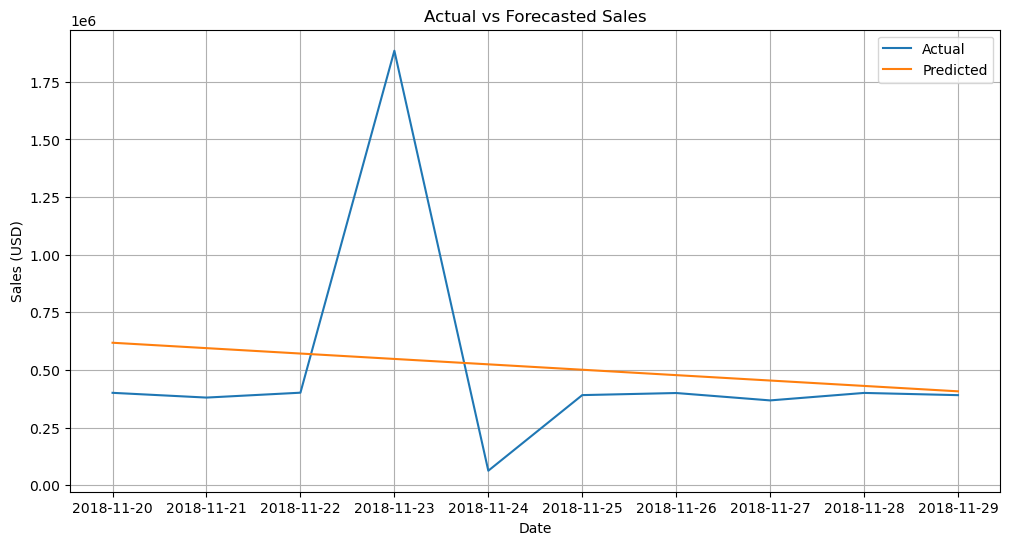

📈 Top Growing Product Categories:
 product_category
505    443451.26
506    347301.76
508    347132.42
503    346344.13
507    339178.47
Name: sales, dtype: float64

💳 Payment Method Preference (%):
 payment_method
credit    57.838314
paypal    42.161686
Name: proportion, dtype: float64


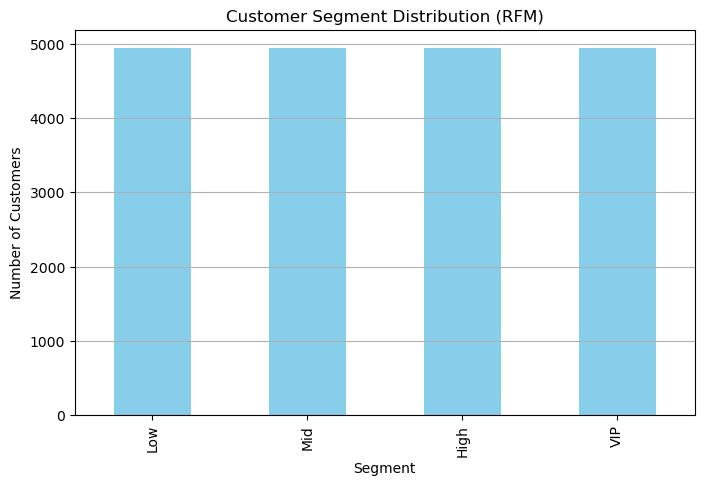


💼 Business Opportunities:
1. Invest in top-selling categories like: 505, 506, 508, 503, 507
2. Leverage PayPal and Credit as preferred methods for upselling.
3. Launch loyalty programs for 'VIP' customers (high spenders).
4. Retarget 'Low' segment customers using discount campaigns.
5. Focus festive campaigns around time periods with spikes in sales.


In [1]:
# 📦 Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# 🔹 Load & Prepare Dataset
df = pd.read_csv("ecommerce_data_final_cleaned.csv")
df = df.drop(columns=["Unnamed: 7"])
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df.rename(columns={'value [USD]': 'sales'}, inplace=True)

# 🔹 Aggregate Sales by Day
daily_sales = df.groupby('date')['sales'].sum().reset_index()

# 🔹 Handle Missing Dates
all_dates = pd.date_range(start=daily_sales['date'].min(), end=daily_sales['date'].max())
daily_sales = daily_sales.set_index('date').reindex(all_dates, fill_value=0).rename_axis('date').reset_index()

# 🔹 Prophet needs 'ds' and 'y'
df_prophet = daily_sales.rename(columns={"date": "ds", "sales": "y"})

# 🔹 Train-Test Split
train_size = int(len(df_prophet) * 0.8)
train = df_prophet[:train_size]
test = df_prophet[train_size:]

# 🔹 Fit Prophet Model
model = Prophet()
model.fit(train)

# 🔹 Forecast
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

# 🔹 Plot Forecast
model.plot(forecast)
plt.title("Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales (USD)")
plt.grid(True)
plt.show()

# 🔹 Compare Predictions with Actual
forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').join(df_prophet.set_index('ds'))
actual = forecast_filtered['y'].dropna()
predicted = forecast_filtered['yhat'].loc[actual.index]

# 🔹 Accuracy Metrics
rmse = np.sqrt(mean_squared_error(actual, predicted))
mae = mean_absolute_error(actual, predicted)

print(f"🔍 RMSE: {rmse:.2f}")
print(f"🔍 MAE: {mae:.2f}")

# 🔹 Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(actual.index, actual.values, label="Actual")
plt.plot(predicted.index, predicted.values, label="Predicted")
plt.title("Actual vs Forecasted Sales")
plt.xlabel("Date")
plt.ylabel("Sales (USD)")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------
# 🔎 Business Opportunity Analysis
# ----------------------------------

# 1️⃣ Top Growing Categories
top_categories = df.groupby('product_category')['sales'].sum().sort_values(ascending=False).head(5)
print("📈 Top Growing Product Categories:\n", top_categories)

# 2️⃣ Payment Method Preference
payment_pref = df['payment_method'].value_counts(normalize=True) * 100
print("\n💳 Payment Method Preference (%):\n", payment_pref)

# 3️⃣ RFM Segmentation (simple version)
today = df['date'].max() + pd.Timedelta(days=1)
rfm = df.groupby('customer_id').agg({
    'date': lambda x: (today - x.max()).days,
    'sales': ['count', 'sum']
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm['Segment'] = pd.qcut(rfm['Monetary'], q=4, labels=['Low', 'Mid', 'High', 'VIP'])

# 4️⃣ Plot Segment Distribution
plt.figure(figsize=(8, 5))
rfm['Segment'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Customer Segment Distribution (RFM)")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.grid(axis='y')
plt.show()

# 5️⃣ Suggest Business Opportunities
print("\n💼 Business Opportunities:")
print("1. Invest in top-selling categories like:", ', '.join(map(str, top_categories.index)))
print("2. Leverage PayPal and Credit as preferred methods for upselling.")
print("3. Launch loyalty programs for 'VIP' customers (high spenders).")
print("4. Retarget 'Low' segment customers using discount campaigns.")
print("5. Focus festive campaigns around time periods with spikes in sales.")
